In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting epoch 1/3


Training Batch: 100%|██████████| 2659/2659 [31:50<00:00,  1.39it/s, Training Loss=0.214]


Epoch 1/3 - Average training loss: 0.3466592161401675
Starting validation for epoch 1/3


Validation Batch: 100%|██████████| 296/296 [01:17<00:00,  3.81it/s]


Epoch 1/3 - Average validation loss: 0.31847983362102833
Starting epoch 2/3


Training Batch: 100%|██████████| 2659/2659 [31:55<00:00,  1.39it/s, Training Loss=0.257]


Epoch 2/3 - Average training loss: 0.28737604151255386
Starting validation for epoch 2/3


Validation Batch: 100%|██████████| 296/296 [01:17<00:00,  3.80it/s]


Epoch 2/3 - Average validation loss: 0.31088918517972974
Starting epoch 3/3


Training Batch: 100%|██████████| 2659/2659 [31:56<00:00,  1.39it/s, Training Loss=0.121]


Epoch 3/3 - Average training loss: 0.23143311485721008
Starting validation for epoch 3/3


Validation Batch: 100%|██████████| 296/296 [01:17<00:00,  3.81it/s]


Epoch 3/3 - Average validation loss: 0.32342062437453784


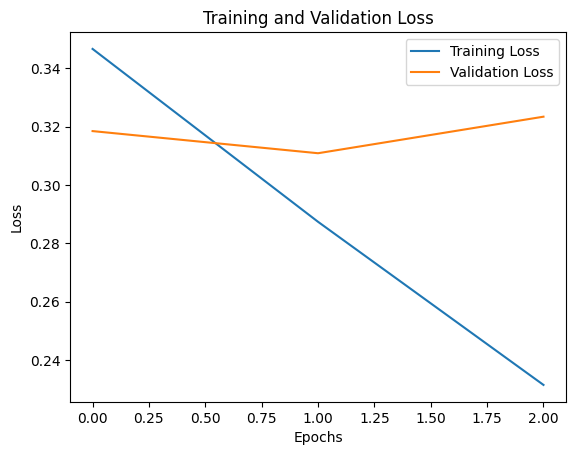

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the preprocessed CSV file
try:
    df = pd.read_csv('Finalpreprocessed_data_no_stopwords.csv')
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Initialize the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dialogues
tokenized_data = tokenizer.batch_encode_plus(
    df['Cleaned_Dialogue'].tolist(),
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Extract input IDs and attention masks from the tokenized data
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Define your emotion labels
emotions = [
    "Happiness", "Contentment", "Confidence", "Neutral", "Sadness",
    "Anger", "Fear", "Surprise", "Disgust", "Love",
    "Excitement", "Anticipation", "Nostalgia", "Confusion",
    "Frustration", "Longing", "Optimism"
]
labels = df[emotions].values

# Split the dataset into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Create datasets and dataloaders
train_dataset = EmotionDataset(train_inputs, train_masks, train_labels)
validation_dataset = EmotionDataset(validation_inputs, validation_masks, validation_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(emotions))
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = BCEWithLogitsLoss()

# Define the number of training epochs
epochs = 3

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    print(f"Starting epoch {epoch+1}/{epochs}")

    batch_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Batch")
    for step, batch in batch_progress:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask)

        loss = loss_fn(outputs.logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_progress.set_postfix({'Training Loss': '{:.3f}'.format(loss.item())})

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    print(f"Starting validation for epoch {epoch+1}/{epochs}")

    for batch in tqdm(validation_loader, desc="Validation Batch"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        loss = loss_fn(outputs.logits, b_labels)
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average validation loss: {avg_val_loss}")

# Plotting the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
try:
    model.save_pretrained('./saved_modelwithoutstopwords')
    tokenizer.save_pretrained('./saved_modelwithoutstopwords')
except Exception as e:
    print(f"Error saving the model: {e}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting epoch 1/3


Training Batch: 100%|██████████| 2766/2766 [31:36<00:00,  1.46it/s, Training Loss=0.417]


Epoch 1/3 - Average training loss: 0.31475406417532925
Starting validation for epoch 1/3


Validation Batch: 100%|██████████| 308/308 [01:13<00:00,  4.17it/s]


Epoch 1/3 - Average validation loss: 0.288388923729782
Starting epoch 2/3


Training Batch: 100%|██████████| 2766/2766 [31:36<00:00,  1.46it/s, Training Loss=0.203]


Epoch 2/3 - Average training loss: 0.2369781885261089
Starting validation for epoch 2/3


Validation Batch: 100%|██████████| 308/308 [01:13<00:00,  4.18it/s]


Epoch 2/3 - Average validation loss: 0.2766947213124919
Starting epoch 3/3


Training Batch: 100%|██████████| 2766/2766 [31:36<00:00,  1.46it/s, Training Loss=0.161]


Epoch 3/3 - Average training loss: 0.17760749209594098
Starting validation for epoch 3/3


Validation Batch: 100%|██████████| 308/308 [01:13<00:00,  4.17it/s]


Epoch 3/3 - Average validation loss: 0.2849620061067792


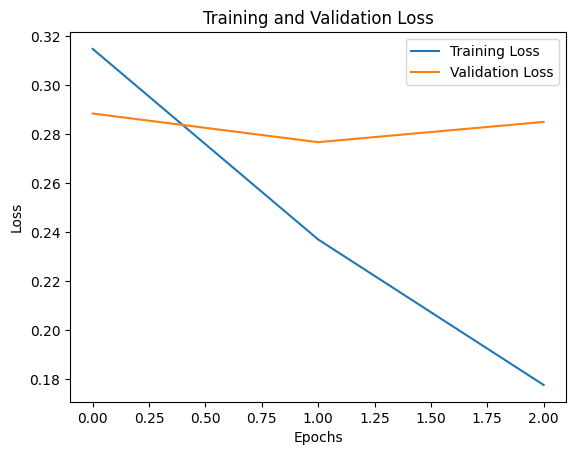

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the preprocessed CSV file
try:
    df = pd.read_csv('Finalpreprocessed_data.csv')
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Initialize the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dialogues
tokenized_data = tokenizer.batch_encode_plus(
    df['Cleaned_Dialogue'].tolist(),
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Extract input IDs and attention masks from the tokenized data
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Define your emotion labels
emotions = [
    "Happiness", "Contentment", "Confidence", "Neutral", "Sadness",
    "Anger", "Fear", "Surprise", "Disgust", "Love",
    "Excitement", "Anticipation", "Nostalgia", "Confusion",
    "Frustration", "Longing", "Optimism"
]
labels = df[emotions].values

# Split the dataset into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Create datasets and dataloaders
train_dataset = EmotionDataset(train_inputs, train_masks, train_labels)
validation_dataset = EmotionDataset(validation_inputs, validation_masks, validation_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(emotions))
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = BCEWithLogitsLoss()

# Define the number of training epochs
epochs = 3

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    print(f"Starting epoch {epoch+1}/{epochs}")

    batch_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Batch")
    for step, batch in batch_progress:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask)

        loss = loss_fn(outputs.logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_progress.set_postfix({'Training Loss': '{:.3f}'.format(loss.item())})

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    print(f"Starting validation for epoch {epoch+1}/{epochs}")

    for batch in tqdm(validation_loader, desc="Validation Batch"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        loss = loss_fn(outputs.logits, b_labels)
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average validation loss: {avg_val_loss}")

# Plotting the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
try:
    model.save_pretrained('./saved_modelwithstopwords')
    tokenizer.save_pretrained('./saved_modelwithstopwords')
except Exception as e:
    print(f"Error saving the model: {e}")


In [ ]:
# Import necessary library
from google.colab import drive
import shutil

# Mount Google Drive

# Define the source and destination paths
source_path = '/content/savedmodelwithstopwords'  # Replace with your directory's path
destination_path = '/content/drive/My Drive/'  # Replace with your desired path in Google Drive

# Move the directory
shutil.move(source_path, destination_path)

'/content/drive/My Drive/savedmodel'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
isimport torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the preprocessed CSV file
try:
    df = pd.read_csv('/content/drive/MyDrive/NLP_Project/Finalpreprocessed_data_no_stopwords.csv')
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Initialize the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dialogues
tokenized_data = tokenizer.batch_encode_plus(
    df['Cleaned_Dialogue'].tolist(),
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Extract input IDs and attention masks from the tokenized data
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Define your emotion labels
emotions = [
    "Happiness", "Contentment", "Confidence", "Neutral", "Sadness",
    "Anger", "Fear", "Surprise", "Disgust", "Love",
    "Excitement", "Anticipation", "Nostalgia", "Confusion",
    "Frustration", "Longing", "Optimism"
]
labels = df[emotions].values

# Split the dataset into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Create datasets and dataloaders
train_dataset = EmotionDataset(train_inputs, train_masks, train_labels)
validation_dataset = EmotionDataset(validation_inputs, validation_masks, validation_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(emotions))
optimizer = AdamW(model.parameters(), lr=5e-4)
loss_fn = BCEWithLogitsLoss()

# Define the number of training epochs
epochs = 5

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    print(f"Starting epoch {epoch+1}/{epochs}")

    batch_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Batch")
    for step, batch in batch_progress:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask)

        loss = loss_fn(outputs.logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_progress.set_postfix({'Training Loss': '{:.3f}'.format(loss.item())})

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    print(f"Starting validation for epoch {epoch+1}/{epochs}")

    for batch in tqdm(validation_loader, desc="Validation Batch"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        loss = loss_fn(outputs.logits, b_labels)
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average validation loss: {avg_val_loss}")

    # Calculate accuracy
    train_preds = torch.sigmoid(model(train_inputs.to(device), attention_mask=train_masks.to(device)).logits).cpu().detach().numpy()
    train_acc = accuracy_score(train_labels, np.round(train_preds))
    train_accuracies.append(train_acc)

    val_preds = torch.sigmoid(model(validation_inputs.to(device), attention_mask=validation_masks.to(device)).logits).cpu().detach().numpy()
    val_acc = accuracy_score(validation_labels, np.round(val_preds))
    val_accuracies.append(val_acc)

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot learning rate schedule
plt.subplot(1, 3, 3)
plt.plot(scheduler.get_lr())
plt.title('Learning Rate Schedule')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()

# Confusion Matrix
model.eval()
conf_matrix_labels = np.argmax(validation_labels, axis=1)
conf_matrix_preds = np.argmax(val_preds, axis=1)
conf_matrix = confusion_matrix(conf_matrix_labels, conf_matrix_preds, labels=np.arange(len(emotions)))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save the model
try:
    model.save_pretrained('/content/drive/MyDrive/NLP_Project/saved_modelwithoutstopwords')
    tokenizer.save_pretrained('/content/drive/MyDrive/NLP_Project/saved_modelwithoutstopwords')
except Exception as e:
    print(f"Error saving the model: {e}")



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Load the preprocessed CSV file
try:
    df = pd.read_csv('/content/drive/MyDrive/NLP_Project/Finalpreprocessed_data_no_stopwords.csv')
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Initialize the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dialogues
tokenized_data = tokenizer.batch_encode_plus(
    df['Cleaned_Dialogue'].tolist(),
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Extract input IDs and attention masks
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Define emotion labels
emotions = [
    "Happiness", "Contentment", "Confidence", "Neutral", "Sadness",
    "Anger", "Fear", "Surprise", "Disgust", "Love",
    "Excitement", "Anticipation", "Nostalgia", "Confusion",
    "Frustration", "Longing", "Optimism"
]
labels = df[emotions].values

# Split dataset into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Create datasets
train_dataset = EmotionDataset(train_inputs, train_masks, train_labels)
validation_dataset = EmotionDataset(validation_inputs, validation_masks, validation_labels)

# DataLoader with reduced batch size
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Initialize BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(emotions))
optimizer = AdamW(model.parameters(), lr=5e-4)
loss_fn = BCEWithLogitsLoss()

# Training setup
epochs = 5
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to calculate metrics in batches
def compute_metrics(model, inputs, masks, labels):
    model.eval()
    total_preds = np.empty((0, len(emotions)))
    total_labels = np.empty((0, len(emotions)))
    with torch.no_grad():
        for i in range(0, inputs.size(0), batch_size):
            batch_input_ids = inputs[i:i+batch_size].to(device)
            batch_input_mask = masks[i:i+batch_size].to(device)
            outputs = model(batch_input_ids, attention_mask=batch_input_mask)
            preds = torch.sigmoid(outputs.logits).cpu().detach().numpy()
            total_preds = np.vstack((total_preds, preds))
            total_labels = np.vstack((total_labels, labels[i:i+batch_size]))

    # Calculate metrics
    accuracy = accuracy_score(np.round(total_preds), total_labels)
    f1 = f1_score(np.round(total_preds), total_labels, average='micro')
    precision = precision_score(np.round(total_preds), total_labels, average='micro')
    recall = recall_score(np.round(total_preds), total_labels, average='micro')
    return accuracy, f1, precision, recall

# Training loop
train_losses = []
val_losses = []
metrics_history = {'train': [], 'val': []}

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    print(f"Starting epoch {epoch+1}/{epochs}")

    for step, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Batch"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask)
        loss = loss_fn(outputs.logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    for batch in tqdm(validation_loader, desc="Validation Batch"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            loss = loss_fn(outputs.logits, b_labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average validation loss: {avg_val_loss}")

    # Calculate metrics
    train_metrics = compute_metrics(model, train_inputs, train_masks, train_labels)
    val_metrics = compute_metrics(model, validation_inputs, validation_masks, validation_labels)
    metrics_history['train'].append(train_metrics)
    metrics_history['val'].append(val_metrics)

    print(f"Epoch {epoch+1}/{epochs} - Training Metrics: Accuracy: {train_metrics[0]}, F1: {train_metrics[1]}, Precision: {train_metrics[2]}, Recall: {train_metrics[3]}")
    print(f"Epoch {epoch+1}/{epochs} - Validation Metrics: Accuracy: {val_metrics[0]}, F1: {val_metrics[1]}, Precision: {val_metrics[2]}, Recall: {val_metrics[3]}")

# Plotting training and validation loss and metrics
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 4, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy, F1, Precision, Recall
# Accuracy, F1, Precision, Recall
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
for i, metric in enumerate(metrics, start=2):
    plt.subplot(1, 4, i - 1)  # Adjust the subplot index
    plt.plot([m[i-2] for m in metrics_history['train']], label=f'Training {metric}')
    plt.plot([m[i-2] for m in metrics_history['val']], label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
# You might need to adjust this part based on how you want to represent the multi-label confusion matrix
conf_matrix_labels = np.argmax(validation_labels, axis=1)
conf_matrix_preds = np.argmax(val_preds, axis=1)
conf_matrix = confusion_matrix(conf_matrix_labels, conf_matrix_preds, labels=np.arange(len(emotions)))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save the model
try:
    model.save_pretrained('/content/drive/MyDrive/NLP_Project/saved_modelwithoutstopwords')
    tokenizer.save_pretrained('/content/drive/MyDrive/NLP_Project/saved_modelwithoutstopwords')
except Exception as e:
    print(f"Error saving the model: {e}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting epoch 1/5


Training Batch: 100%|██████████| 5317/5317 [11:14<00:00,  7.88it/s]


Epoch 1/5 - Average training loss: 0.40377058729162246


Validation Batch: 100%|██████████| 591/591 [00:22<00:00, 25.73it/s]


Epoch 1/5 - Average validation loss: 0.3975863928722246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5 - Training Metrics: Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0
Epoch 1/5 - Validation Metrics: Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0
Starting epoch 2/5


Training Batch: 100%|██████████| 5317/5317 [11:15<00:00,  7.87it/s]


Epoch 2/5 - Average training loss: 0.3991579915743159


Validation Batch: 100%|██████████| 591/591 [00:23<00:00, 25.67it/s]


Epoch 2/5 - Average validation loss: 0.39724435998905333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5 - Training Metrics: Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0
Epoch 2/5 - Validation Metrics: Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0
Starting epoch 3/5


Training Batch: 100%|██████████| 5317/5317 [11:15<00:00,  7.87it/s]


Epoch 3/5 - Average training loss: 0.3984497187728157


Validation Batch: 100%|██████████| 591/591 [00:22<00:00, 25.74it/s]


Epoch 3/5 - Average validation loss: 0.39796381356752464


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/5 - Training Metrics: Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0
Epoch 3/5 - Validation Metrics: Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0
Starting epoch 4/5


Training Batch: 100%|██████████| 5317/5317 [11:15<00:00,  7.87it/s]


Epoch 4/5 - Average training loss: 0.3976456671785048


Validation Batch: 100%|██████████| 591/591 [00:23<00:00, 25.67it/s]


Epoch 4/5 - Average validation loss: 0.3984033981253048


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/5 - Training Metrics: Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0
Epoch 4/5 - Validation Metrics: Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0
Starting epoch 5/5


Training Batch: 100%|██████████| 5317/5317 [11:15<00:00,  7.87it/s]


Epoch 5/5 - Average training loss: 0.39682289111910174


Validation Batch: 100%|██████████| 591/591 [00:22<00:00, 25.72it/s]


Epoch 5/5 - Average validation loss: 0.3982718154762804


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/5 - Training Metrics: Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0
Epoch 5/5 - Validation Metrics: Accuracy: 0.0, F1: 0.0, Precision: 0.0, Recall: 0.0


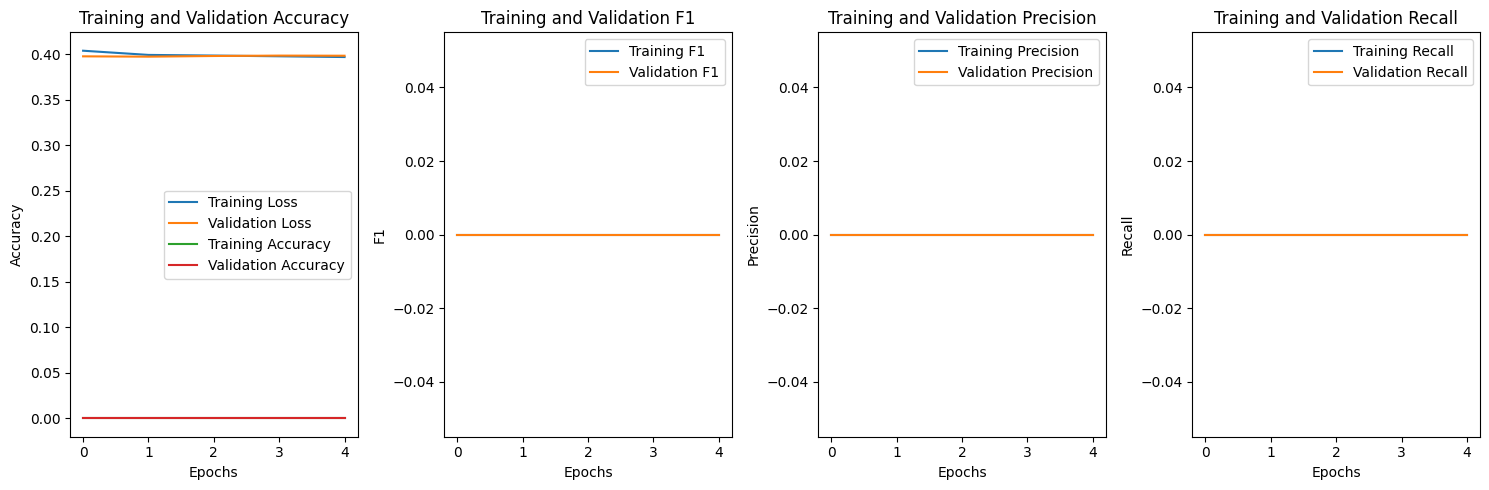

NameError: ignored

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Load the preprocessed CSV file
try:
    df = pd.read_csv('/content/drive/MyDrive/NLP_Project/Finalpreprocessed_data_no_stopwords.csv')
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Initialize the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dialogues
tokenized_data = tokenizer.batch_encode_plus(
    df['Cleaned_Dialogue'].tolist(),
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Extract input IDs and attention masks
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Define emotion labels
emotions = [
    "Happiness", "Contentment", "Confidence", "Neutral", "Sadness",
    "Anger", "Fear", "Surprise", "Disgust", "Love",
    "Excitement", "Anticipation", "Nostalgia", "Confusion",
    "Frustration", "Longing", "Optimism"
]
labels = df[emotions].values

# Split dataset into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Create datasets
train_dataset = EmotionDataset(train_inputs, train_masks, train_labels)
validation_dataset = EmotionDataset(validation_inputs, validation_masks, validation_labels)

# DataLoader with reduced batch size
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Initialize BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(emotions))
optimizer = AdamW(model.parameters(), lr=5e-4)
loss_fn = BCEWithLogitsLoss()

# Training setup
epochs = 5
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to calculate metrics in batches
def compute_metrics(model, inputs, masks, labels):
    model.eval()
    total_preds = np.empty((0, len(emotions)))
    total_labels = np.empty((0, len(emotions)))
    with torch.no_grad():
        for i in range(0, inputs.size(0), batch_size):
            batch_input_ids = inputs[i:i+batch_size].to(device)
            batch_input_mask = masks[i:i+batch_size].to(device)
            outputs = model(batch_input_ids, attention_mask=batch_input_mask)
            preds = torch.sigmoid(outputs.logits).cpu().detach().numpy()
            total_preds = np.vstack((total_preds, preds))
            total_labels = np.vstack((total_labels, labels[i:i+batch_size]))

    # Calculate metrics
    accuracy = accuracy_score(np.round(total_preds), total_labels)
    f1 = f1_score(np.round(total_preds), total_labels, average='micro')
    precision = precision_score(np.round(total_preds), total_labels, average='micro')
    recall = recall_score(np.round(total_preds), total_labels, average='micro')
    return accuracy, f1, precision, recall

# Training loop
train_losses = []
val_losses = []
metrics_history = {'train': [], 'val': []}

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    print(f"Starting epoch {epoch+1}/{epochs}")

    for step, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Batch"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask)
        loss = loss_fn(outputs.logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    for batch in tqdm(validation_loader, desc="Validation Batch"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            loss = loss_fn(outputs.logits, b_labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average validation loss: {avg_val_loss}")

    # Calculate metrics
    train_metrics = compute_metrics(model, train_inputs, train_masks, train_labels)
    val_metrics = compute_metrics(model, validation_inputs, validation_masks, validation_labels)
    metrics_history['train'].append(train_metrics)
    metrics_history['val'].append(val_metrics)

    print(f"Epoch {epoch+1}/{epochs} - Training Metrics: Accuracy: {train_metrics[0]}, F1: {train_metrics[1]}, Precision: {train_metrics[2]}, Recall: {train_metrics[3]}")
    print(f"Epoch {epoch+1}/{epochs} - Validation Metrics: Accuracy: {val_metrics[0]}, F1: {val_metrics[1]}, Precision: {val_metrics[2]}, Recall: {val_metrics[3]}")

# Plotting training and validation loss and metrics
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 4, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy, F1, Precision, Recall
# Accuracy, F1, Precision, Recall
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
for i, metric in enumerate(metrics, start=2):
    plt.subplot(1, 4, i - 1)  # Adjust the subplot index
    plt.plot([m[i-2] for m in metrics_history['train']], label=f'Training {metric}')
    plt.plot([m[i-2] for m in metrics_history['val']], label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
# You might need to adjust this part based on how you want to represent the multi-label confusion matrix
conf_matrix_labels = np.argmax(validation_labels, axis=1)
conf_matrix_preds = np.argmax(val_preds, axis=1)
conf_matrix = confusion_matrix(conf_matrix_labels, conf_matrix_preds, labels=np.arange(len(emotions)))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save the model
try:
    model.save_pretrained('/content/drive/MyDrive/NLP_Project/saved_modelwithoutstopwords')
    tokenizer.save_pretrained('/content/drive/MyDrive/NLP_Project/saved_modelwithoutstopwords')
except Exception as e:
    print(f"Error saving the model: {e}")
